In [310]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
from xgboost import XGBClassifier
import xgboost as xgb
import json

In [311]:
aapl = yf.download("AAPL", start="2005-01-01", group_by="column", auto_adjust=False)


[*********************100%***********************]  1 of 1 completed


In [312]:
aapl.columns = aapl.columns.get_level_values(0)
print(aapl.columns)
aapl.tail()


Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2025-11-06,269.508728,269.769989,273.399994,267.890015,267.890015,51204000
2025-11-07,268.209991,268.470001,272.290009,266.769989,269.799988,48227400
2025-11-10,269.429993,269.429993,273.730011,267.459991,268.959991,41312400
2025-11-11,275.250000,275.250000,275.910004,269.799988,269.809998,46138500
2025-11-12,275.190002,275.190002,275.350006,271.869995,275.075012,18255659


In [313]:
aapl["return"] = aapl["Adj Close"] / aapl["Adj Close"].shift(1) - 1
aapl


Price,Adj Close,Close,High,Low,Open,Volume,return
Date,,,,,,,
2005-01-03,0.949067,1.130179,1.162679,1.117857,1.156786,691992000,NaN
2005-01-04,0.958814,1.141786,1.169107,1.124464,1.139107,1096810400,0.010270
2005-01-05,0.967211,1.151786,1.165179,1.143750,1.151071,680433600,0.008758
2005-01-06,0.967961,1.152679,1.159107,1.130893,1.154821,705555200,0.000775
2005-01-07,1.038440,1.236607,1.243393,1.156250,1.160714,2227450400,0.072811
...,...,...,...,...,...,...,...
2025-11-06,269.508728,269.769989,273.399994,267.890015,267.890015,51204000,-0.001370
2025-11-07,268.209991,268.470001,272.290009,266.769989,269.799988,48227400,-0.004819
2025-11-10,269.429993,269.429993,273.730011,267.459991,268.959991,41312400,0.004549


In [314]:
aapl["logreturn"] = np.log(aapl["Adj Close"]).diff()
aapl

Price,Adj Close,Close,High,Low,Open,Volume,return,logreturn
Date,,,,,,,,
2005-01-03,0.949067,1.130179,1.162679,1.117857,1.156786,691992000,NaN,NaN
2005-01-04,0.958814,1.141786,1.169107,1.124464,1.139107,1096810400,0.010270,0.010218
2005-01-05,0.967211,1.151786,1.165179,1.143750,1.151071,680433600,0.008758,0.008720
2005-01-06,0.967961,1.152679,1.159107,1.130893,1.154821,705555200,0.000775,0.000775
2005-01-07,1.038440,1.236607,1.243393,1.156250,1.160714,2227450400,0.072811,0.070282
...,...,...,...,...,...,...,...,...
2025-11-06,269.508728,269.769989,273.399994,267.890015,267.890015,51204000,-0.001370,-0.001371
2025-11-07,268.209991,268.470001,272.290009,266.769989,269.799988,48227400,-0.004819,-0.004831
2025-11-10,269.429993,269.429993,273.730011,267.459991,268.959991,41312400,0.004549,0.004538


In [315]:
print(aapl["logreturn"].mean(), aapl["logreturn"].std())


0.0010801557869510971 0.020308560056066214


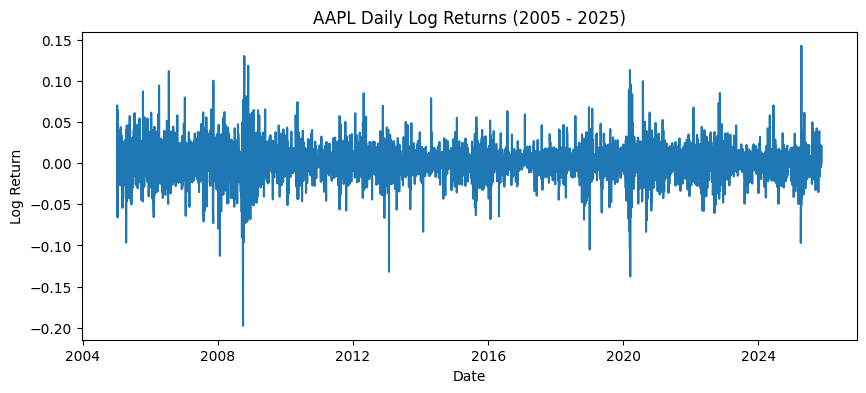

In [316]:
plt.figure(figsize=(10,4))
plt.plot(aapl.index, aapl["logreturn"])
plt.title("AAPL Daily Log Returns (2005 - 2025)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

In [317]:
r = aapl["logreturn"]

# data checks
checks = {}

checks["n_total"] = r.size
checks["n_null"] = r.isna().sum()
checks["n_posinf"] = np.isposinf(r.fillna(np.inf)).sum()
checks["n_neginf"] = np.isneginf(r.fillna(-np.inf)).sum()

idx = aapl.index
checks["index_is_datetime"] = isinstance(idx, pd.DatetimeIndex)
checks["index_is_monotic_increasing"] = idx.is_monotonic_increasing
checks["n_duplicates_in_index"] = idx.duplicated().sum()

checks["min"] = r.min(skipna=True)
checks["max"] = r.max(skipna=True)

checks
r = aapl["logreturn"].dropna()


In [318]:
# mean and velocity of aaple

r = aapl["logreturn"].dropna()
mean_daily = r.mean()
std_daily = r.std(ddof=1)

mean_daily, std_daily

(np.float64(0.0010801557869510971), np.float64(0.020308560056066214))

In [319]:
# Sharpe

NUMBER_OF_TRADING_DAYS = 252

ann_mean_log = mean_daily * NUMBER_OF_TRADING_DAYS
ann_vol = std_daily * (NUMBER_OF_TRADING_DAYS ** 0.5)
sharpe = ann_mean_log / ann_vol

ann_simple = np.exp(ann_mean_log) - 1
ann_mean_log, ann_simple, ann_vol, sharpe

(np.float64(0.27219925831167646),
 np.float64(0.3128485712400437),
 np.float64(0.322388396365027),
 np.float64(0.8443208917590092))

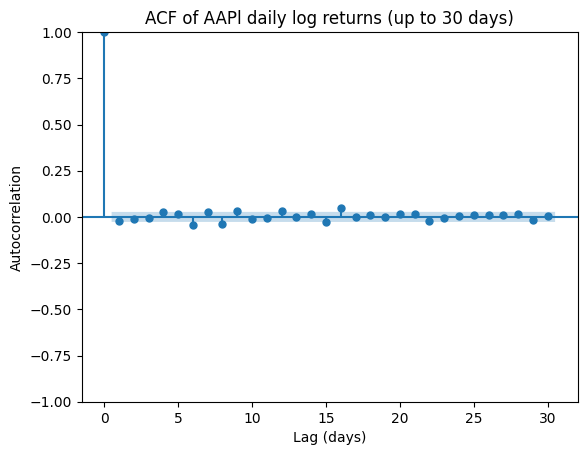

In [320]:
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt

plot_acf(r, lags=30)
plt.title("ACF of AAPl daily log returns (up to 30 days)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.show()



We see from this plot that today's return has no meaningful linear relationship with yesterday's, or with any day up to a month back
First bar is 1 since it's just the correlation of the series with itself
No momentum, so just because Apple was up yesterday, we can't conclude to buy today

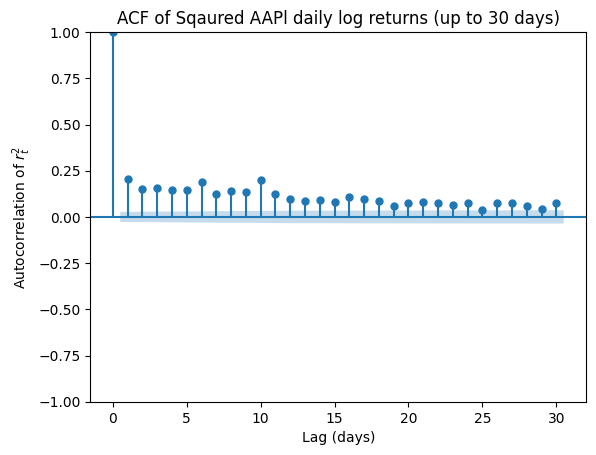

In [321]:
r2 = r ** 2

plot_acf(r2, lags=30)
plt.title("ACF of Sqaured AAPl daily log returns (up to 30 days)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation of $r_t^2$")
plt.show()

The bars are positive and significant, so when a market has a large/small swing today (up or down since it's squared), it's more likely that tomorrow will also have a large/small swing, but we can't predict which direction the swing will be in. 


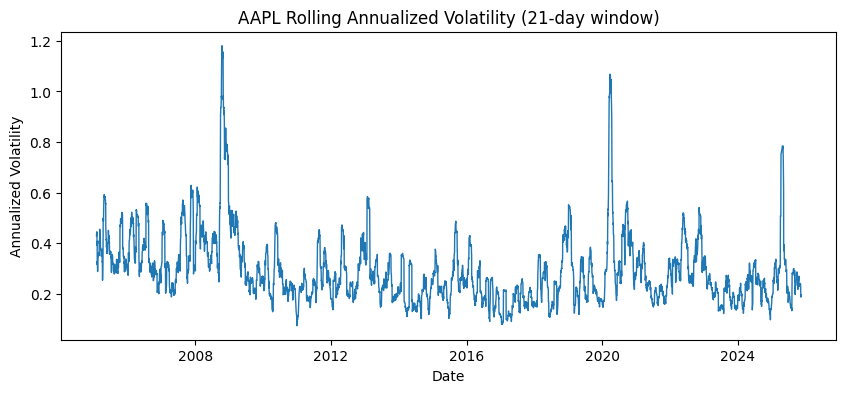

0.25830429753718565

In [322]:
import numpy as np

window = 21
roll_vol_ann = r.rolling(window).std(ddof=1) * np.sqrt(NUMBER_OF_TRADING_DAYS)

plt.figure(figsize=(10,4))
plt.plot(roll_vol_ann, linewidth=1)
plt.title(f"AAPL Rolling Annualized Volatility ({window}-day window)")
plt.ylabel("Annualized Volatility")
plt.xlabel("Date")
plt.show()

roll_vol_median = roll_vol_ann.median()
float(roll_vol_median)


The line is the estimated volatility for each day using only the previous 21 days, without peeking ahead.
Spikes represent turbulent regions, and troughs are calm regions.

25.85% is the median annualized volume across the sample

This shows when risk was high/low and how quickly it changes.



In [323]:
# fit t-GARCH(1,1) 
import arch
from arch import arch_model

r_pct = 100 * r
r_pct.head()

am = arch_model(
    r_pct,
    mean="Constant",
    vol="Garch",
    p=1, q=1,
    dist="t"
)

result = am.fit(update_freq=10, disp="off")
print(result.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    logreturn   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -10377.9
Distribution:      Standardized Student's t   AIC:                           20765.7
Method:                  Maximum Likelihood   BIC:                           20798.5
                                              No. Observations:                 5249
Date:                      Wed, Nov 12 2025   Df Residuals:                     5248
Time:                              13:44:10   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

We see that a + b is very close to 1, so there is long-lasting volatility

In [324]:
# get residuals
resid = result.resid
sigma = result.conditional_volatility # pred std dev per day
std_resid = resid / sigma # should be student-t, iid

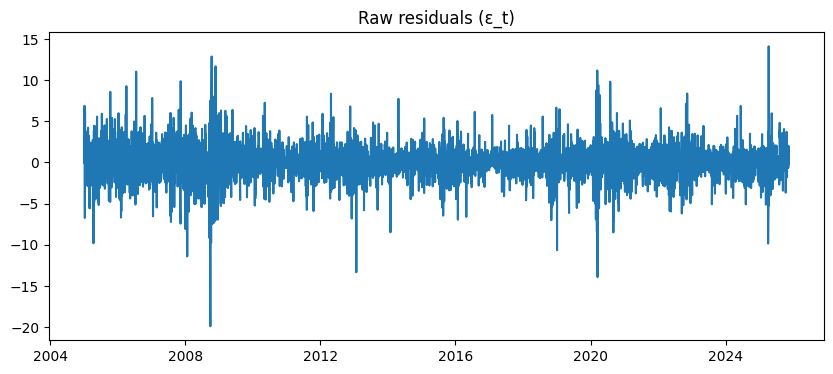

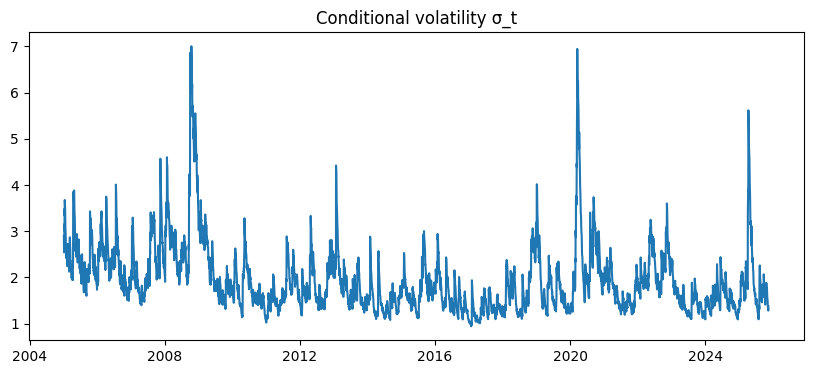

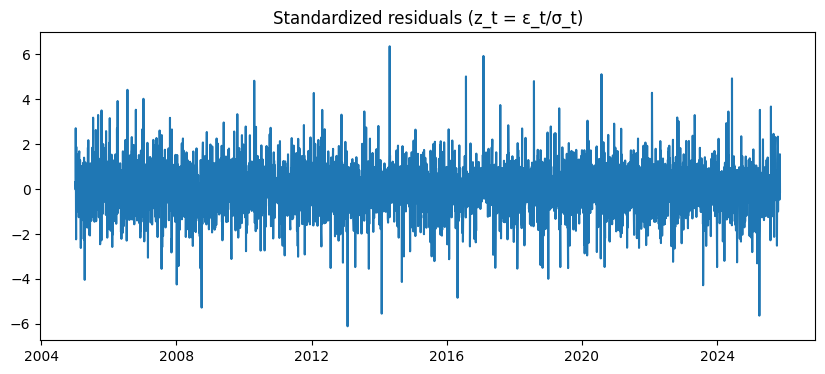

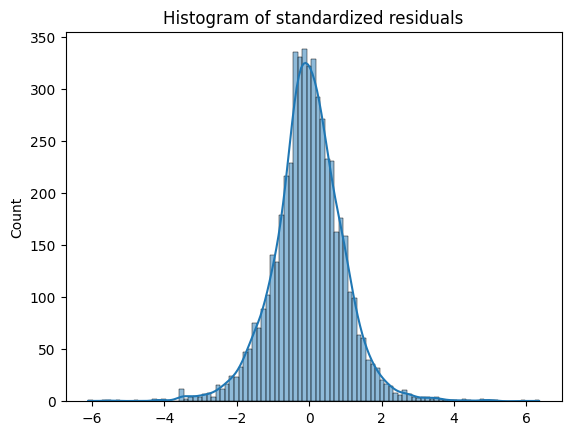

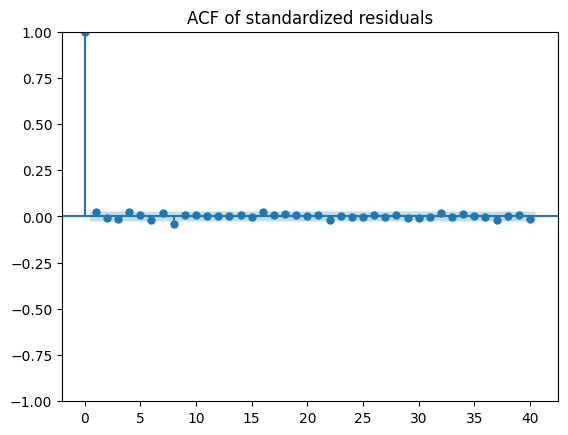

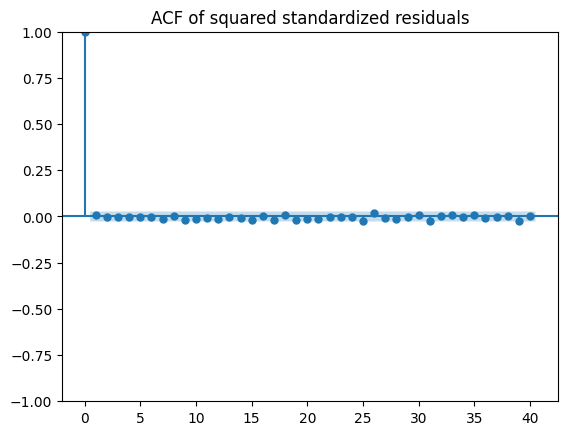

In [325]:
#visualize

plt.figure(figsize=(10,4))
plt.plot(resid)
plt.title("Raw residuals (ε_t)")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(sigma)
plt.title("Conditional volatility σ_t")
plt.show()


plt.figure(figsize=(10,4))
plt.plot(std_resid)
plt.title("Standardized residuals (z_t = ε_t/σ_t)")
plt.show()

sns.histplot(std_resid, kde=True)
plt.title("Histogram of standardized residuals")
plt.show()

plot_acf(std_resid, lags=40)
plt.title("ACF of standardized residuals")
plt.show()

plot_acf(std_resid**2, lags=40)
plt.title("ACF of squared standardized residuals")
plt.show()


In [326]:
# Ljung-Box Test: are the residuals autocorrelated, if past values help predict current ones

lb_resid = acorr_ljungbox(std_resid, lags=[10,20], return_df=True)

lb_sqresid = acorr_ljungbox(std_resid**2, lags=[10,20], return_df=True)

print("Ljunb-Box test on standardized residuals:")
print(lb_resid)
print("\nLB test on squared standardized residuals:")
print(lb_sqresid)


Ljunb-Box test on standardized residuals:
      lb_stat  lb_pvalue
10  20.701335   0.023275
20  26.119303   0.161908

LB test on squared standardized residuals:
      lb_stat  lb_pvalue
10   4.875625   0.899330
20  14.243225   0.817953


Any short-term corerlation that exists is small and dies off quickly.

From the sqaured, we see that they are completley random, since the null hypothesis was no autocorrelation, so no leftover volatility dependence. 

In [327]:
# Arch-LM Test
# do large shocks still tend to follow each other

arch_test = het_arch(std_resid)
print("ARCH-LM test results:")
print(f"LM stat = {arch_test[0]:.4f}, p-value = {arch_test[1]:.4f}")


ARCH-LM test results:
LM stat = 5.0233, p-value = 0.8896


No ARCH effects left, so the volatility model is good, volatility is fully captured.

In [328]:
# Forecast

forecasts = result.forecast(horizon=100)
forecast_var = forecasts.variance[-1:].T
forecast_var

Date,2025-11-12
h.001,1.773709
h.002,1.819486
h.003,1.864754
h.004,1.909520
h.005,1.953788
...,...
h.096,4.468925
h.097,4.484769
h.098,4.500438
h.099,4.515933


This is the model's expected condtiional variance for that next day, given what it knows. They are measures of uncertainity, so how risky the market will be each day
Right now, the model believes that the volatility is slightly below its long run level, so it is creeping upward

In [329]:
p = result.params
omega = p['omega']
alpha = p['alpha[1]']
beta  = p['beta[1]']

long_run_var = omega / (1 - alpha - beta)
long_run_vol = long_run_var**0.5
ann_vol = long_run_vol * (252**0.5)

print(f"Long-run variance: {long_run_var:.4f}")
print(f"Long-run daily vol: {long_run_vol:.2f}%")
print(f"Long-run annualized vol: {ann_vol:.2f}%")


Long-run variance: 5.8957
Long-run daily vol: 2.43%
Long-run annualized vol: 38.54%


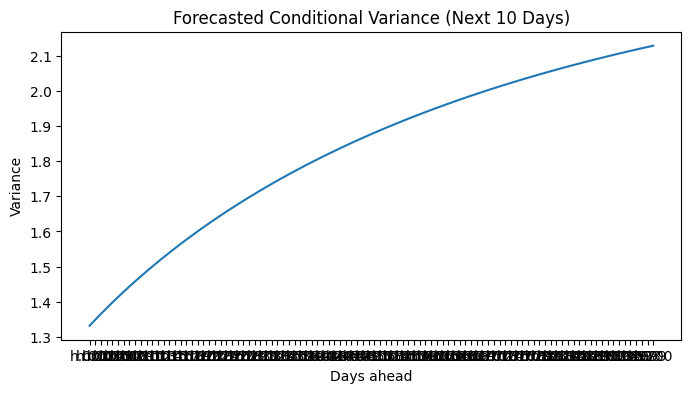

In [330]:
# Visualize future risk levels

plt.figure(figsize=(8,4))
plt.plot(forecast_var**0.5)
plt.title("Forecasted Conditional Variance (Next 10 Days)")
plt.xlabel("Days ahead")
plt.ylabel("Variance")
plt.show()

In [331]:



mu = float(result.params['mu'])          # mean (%/day)
nu = float(result.params['nu'])          # t degrees of freedom


forecasts = result.forecast(horizon=1)
var_t1 = float(result.forecast(horizon=1).variance.iloc[-1, 0])   # variance for h.01 (percent^2/day)
sigma_t1 = np.sqrt(var_t1)                        # volatility for h.01 (percent/day)

# confidence levels#
levels = {'VaR95': 0.05, 'VaR99': 0.01}


out = {}
for name, alpha in levels.items():
    q = st.t.ppf(alpha, df=nu)                   # negative number
    var_return = mu + sigma_t1 * q               # in percent
    var_loss   = -var_return                      # loss convention (positive)
    out[name] = {'return_VaR_%': var_return, 'loss_VaR_%': var_loss}

out, mu, sigma_t1, nu


({'VaR95': {'return_VaR_%': np.float64(-2.5577427188728357),
   'loss_VaR_%': np.float64(2.5577427188728357)},
  'VaR99': {'return_VaR_%': np.float64(-4.411238460738568),
   'loss_VaR_%': np.float64(4.411238460738568)}},
 0.15148049666073152,
 np.float64(1.3318065636208034),
 4.794885105955983)

There is a 5% chance the loss exceeds 2.689%

In [332]:
# Multi day VaR

horizon = 10
alpha = 0.05
forecasts = result.forecast(horizon=horizon)
vars_horizon = forecasts.variance.iloc[-1].values # each days forecast var from model
sigma_h = np.sqrt(np.sum(vars_horizon))  # 10 day forecased volatility

# student t quantile
q = st.t.ppf(alpha,df=nu)

# multi day
var_horizon_return = mu*horizon + sigma_h*q # expected h-day return quantile 
var_horizon_loss = -var_horizon_return


print(f"{horizon}-day 95% VaR (return): {var_horizon_return:.2f}%")
print(f"{horizon}-day 95% VaR (loss):   {var_horizon_loss:.2f}%")


10-day 95% VaR (return): -7.52%
10-day 95% VaR (loss):   7.52%


There is a 7% chance over the next 10 trading thats that the total loss will exceed 7.9%.

In [333]:
# Expected Shortfall
# If worst a% days happen, how bad are they on average? 
# mean loss beyond VaR


alpha = 0.05 # 94% ES
q = st.t.ppf(alpha, df=nu)
pdf = st.t.pdf(q,df=nu)

multiplier = (nu + q**2) / ((nu - 1) * alpha) * pdf

es_return = mu - sigma_t1 * multiplier
es_loss = -es_return


print(f"1-day 95% ES (return): {es_return:.2f}%")
print(f"1-day 95% ES (loss):   {es_loss:.2f}%")



1-day 95% ES (return): -3.76%
1-day 95% ES (loss):   3.76%


We see that if tomorrow is included in the worst 5% of days, the average loss is about 1.19%

In [334]:
# Test 1-day Var to check if model matches reality
# Do x% of days break the 95%VaR and do they happen iid


alpha = 0.05
history = 1000
rets = r_pct.loc['2020-01-01':].dropna()
dates = rets.index
returns = rets.values

VaR_pred = []
actual = []

for t in range(history, len(returns)-1):
    #fit the model up to day t
    y = pd.Series(rets[t-history:t], index=dates[t-history:t])
    am = arch_model(y, mean="Constant", vol="Garch", p=1, q=1, dist="t")
    fitted = am.fit(disp="off")

    # params and forecast next-day variance
    mu = float(fitted.params['mu'])
    nu = float(fitted.params['nu'])
    var_next = float(fitted.forecast(horizon=1).variance.iloc[-1,0])
    sigma_next = np.sqrt(var_next)

    # computer 1-dat VaR
    q = st.t.ppf(alpha, df=nu)
    VaR_next = mu + sigma_next*q
    VaR_pred.append(VaR_next)

    actual.append(returns[t+1])

backtest = pd.DataFrame({
    "Date": dates[history+1:],
    "Return": actual,
    "VaR": VaR_pred
}).set_index("Date")

# check when they exceed

backtest["Exceed"] = (backtest["Return"] < backtest["VaR"]).astype(int)
backtest.head()




,Return,VaR,Exceed
Date,,,
2023-12-22,-0.556295,-2.151589,0
2023-12-26,-0.284515,-2.084684,0
2023-12-27,0.051792,-2.056860,0
2023-12-28,0.222387,-2.002883,0
2023-12-29,-0.543904,-1.934511,0


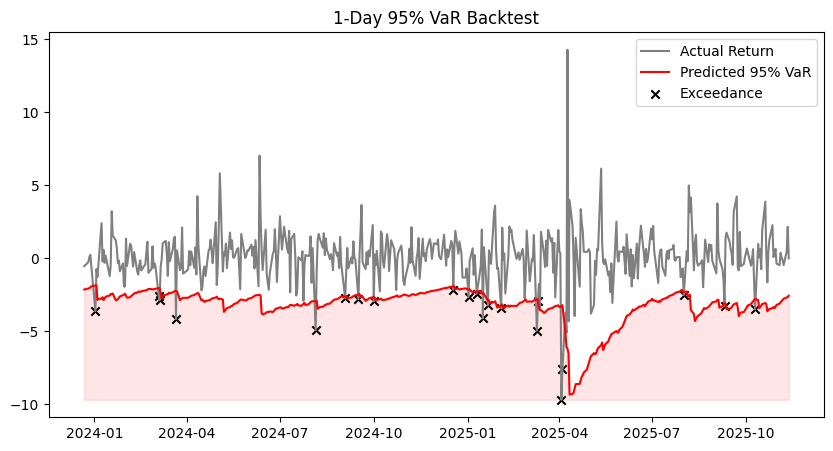

In [335]:
plt.figure(figsize=(10,5))
plt.plot(backtest["Return"], label="Actual Return", color="gray")
plt.plot(backtest["VaR"], label="Predicted 95% VaR", color="red")
plt.fill_between(backtest.index, backtest["VaR"], min(backtest["Return"]), color="red", alpha=0.1)
plt.scatter(backtest.index[backtest["Exceed"]==1], backtest["Return"][backtest["Exceed"]==1],
            color="black", marker="x", label="Exceedance")
plt.legend(); plt.title("1-Day 95% VaR Backtest"); plt.show()

In [336]:
# Frequency (Kupiec Test)

n = len(backtest)
x = backtest["Exceed"].sum()
p_hat = x / n
LR_uc = -2 * ((n - x) * np.log((1 - alpha) / (1 - p_hat)) + x * np.log(alpha / p_hat) )
p_uc = 1 - st.chi2.cdf(LR_uc, df=1)


print(f"Exceedances {x}/{n} = {p_hat:.2%}, Kupiec p-value = {p_uc:.3f}")

Exceedances 21/474 = 4.43%, Kupiec p-value = 0.562


From here we see that the model overestiamtes risk.

In [337]:
import numpy as np, pandas as pd, scipy.stats as st
from arch import arch_model

alpha = 0.05
window = 750                 # ~3y; use 500 for faster response
series = r_pct.loc['2020-01-01':].dropna()
dates, rets = series.index, series.values

VaR, realized = [], []
for t in range(window, len(rets)-1):
    y = pd.Series(rets[t-window:t], index=dates[t-window:t])
    am = arch_model(y, mean="Constant", vol="Garch", p=1, q=1, dist="t")
    res = am.fit(disp="off")
    mu, nu = float(res.params['mu']), float(res.params['nu'])
    sig1 = float(res.forecast(horizon=1).variance.iloc[-1,0])**0.5
    q = st.t.ppf(alpha, df=nu)
    VaR.append(mu + sig1*q)           # return VaR (%)
    realized.append(rets[t+1])

bt = pd.DataFrame({"Return": realized, "VaR": VaR}, index=dates[window+1:])
bt["Exceed"] = (bt["Return"] <= bt["VaR"]).astype(int)

# Kupiec
n, x = len(bt), int(bt["Exceed"].sum())
p_hat = x/n
LR_uc = -2*np.log(((1-alpha)**(n-x)*alpha**x)/((1-p_hat)**(n-x)*p_hat**x))
p_uc = 1 - st.chi2.cdf(LR_uc, 1)
print(f"POST-2020 95% VaR: breaches {x}/{n} = {p_hat:.2%}, Kupiec p={p_uc:.3f}")


POST-2020 95% VaR: breaches 26/724 = 3.59%, Kupiec p=0.068


Modeling


In [338]:
# Target: tomorrow's direction at t+1

df = aapl[['Adj Close', 'logreturn']].copy()

df['y'] = (df['logreturn'].shift(-1) > 0).astype(int)

df = df.dropna(subset=['logreturn', 'y'])
df

Price,Adj Close,logreturn,y
Date,,,
2005-01-04,0.958814,0.010218,1
2005-01-05,0.967211,0.008720,1
2005-01-06,0.967961,0.000775,1
2005-01-07,1.038440,0.070282,0
2005-01-10,1.034092,-0.004196,0
...,...,...,...
2025-11-06,269.508728,-0.001371,0
2025-11-07,268.209991,-0.004831,1
2025-11-10,269.429993,0.004538,1


In [339]:
#integrity checks

df[['logreturn', 'y']].isna().sum(), df['y'].mean(),


(Price
 logreturn    0
 y            0
 dtype: int64,
 np.float64(0.5309582777671937))

In [340]:
# Feature Set v1 to predict t+1


# Momentum

# 5 day momentum
df['mom5'] = df['logreturn'].rolling(5).mean()

# 10 day momentum
df['mom10'] = df['logreturn'].rolling(10).mean()

# rate of change for 5 days
df['roc5'] = df['Adj Close'].pct_change(5)
df, df[['mom5','mom10','roc5']].corr(), 



(Price        Adj Close  logreturn  y      mom5     mom10      roc5
 Date                                                              
 2005-01-04    0.958814   0.010218  1       NaN       NaN       NaN
 2005-01-05    0.967211   0.008720  1       NaN       NaN       NaN
 2005-01-06    0.967961   0.000775  1       NaN       NaN       NaN
 2005-01-07    1.038440   0.070282  0       NaN       NaN       NaN
 2005-01-10    1.034092  -0.004196  0  0.017160       NaN       NaN
 ...                ...        ... ..       ...       ...       ...
 2025-11-06  269.508728  -0.001371  0 -0.001205  0.003850 -0.006006
 2025-11-07  268.209991  -0.004831  1 -0.001410  0.002127 -0.007027
 2025-11-10  269.429993   0.004538  1  0.000476  0.000327  0.002383
 2025-11-11  275.250000   0.021371  0  0.004016  0.002394  0.020282
 2025-11-12  275.190002  -0.000218  0  0.003898  0.002112  0.019682
 
 [5249 rows x 6 columns],
 Price      mom5     mom10     roc5
 Price                             
 mom5   1.000000

In [341]:
# Volatlity

# 10 day volatility
df['vol10'] = df['logreturn'].rolling(10).std()
df['vol20'] = df['logreturn'].rolling(20).std()

df

Price,Adj Close,logreturn,y,mom5,mom10,roc5,vol10,vol20
Date,,,,,,,,
2005-01-04,0.958814,0.010218,1,NaN,NaN,NaN,NaN,NaN
2005-01-05,0.967211,0.008720,1,NaN,NaN,NaN,NaN,NaN
2005-01-06,0.967961,0.000775,1,NaN,NaN,NaN,NaN,NaN
2005-01-07,1.038440,0.070282,0,NaN,NaN,NaN,NaN,NaN
2005-01-10,1.034092,-0.004196,0,0.017160,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2025-11-06,269.508728,-0.001371,0,-0.001205,0.003850,-0.006006,0.008260,0.014828
2025-11-07,268.209991,-0.004831,1,-0.001410,0.002127,-0.007027,0.008073,0.012006
2025-11-10,269.429993,0.004538,1,0.000476,0.000327,0.002383,0.003993,0.011944


In [342]:
# Trend & Deviation

# z-score vs 20 day mean
# close - MA / SD

ma20 = df['Adj Close'].rolling(20).mean()
sd20 = df['Adj Close'].rolling(20).std()

df['z_ma20'] = (df['Adj Close'] - ma20) / sd20


# Bollinger %b: scale relative to range
roll_min = df['Adj Close'].rolling(20).min()
roll_max = df['Adj Close'].rolling(20).max()
df['bbp20'] = (df['Adj Close'] - roll_min) / (roll_max - roll_min)

df[['z_ma20','bbp20']].describe(),df['bbp20'].between(0,1).mean()  

(Price       z_ma20        bbp20
 count  5230.000000  5230.000000
 mean      0.351701     0.616150
 std       1.291095     0.355880
 min      -3.442426     0.000000
 25%      -0.695218     0.294338
 50%       0.580214     0.715595
 75%       1.398832     0.963808
 max       3.480580     1.000000,
 np.float64(0.9963802629072204))

In [343]:
# Skewness and Kurtosis

df['skew20'] = df['logreturn'].rolling(20).skew()
df['kurt20'] = df['logreturn'].rolling(20).kurt()
df

Price,Adj Close,logreturn,y,mom5,mom10,roc5,vol10,vol20,z_ma20,bbp20,skew20,kurt20
Date,,,,,,,,,,,,
2005-01-04,0.958814,0.010218,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,0.967211,0.008720,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,0.967961,0.000775,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,1.038440,0.070282,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,1.034092,-0.004196,0,0.017160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,269.508728,-0.001371,0,-0.001205,0.003850,-0.006006,0.008260,0.014828,0.902408,0.937620,-0.119356,2.630586
2025-11-07,268.209991,-0.004831,1,-0.001410,0.002127,-0.007027,0.008073,0.012006,0.690980,0.877662,1.210170,2.589485
2025-11-10,269.429993,0.004538,1,0.000476,0.000327,0.002383,0.003993,0.011944,0.753283,0.928651,1.296301,2.849353


In [344]:
# Clean up Nans

feature_cols = [
    'mom5', 'mom10', 'roc5',
    'vol10', 'vol20',
    'z_ma20', 'bbp20',
    'skew20', 'kurt20'
]

df_no_nan = df[['logreturn', 'y'] + feature_cols].dropna()
df_no_nan.shape, df_no_nan.isna().sum(), df_no_nan[feature_cols].describe().T.head(10)
df_no_nan.loc['2010']

Price,logreturn,y,mom5,mom10,roc5,vol10,vol20,z_ma20,bbp20,skew20,kurt20
Date,,,,,,,,,,,
2010-01-04,0.015445,1,0.004699,0.010926,0.023775,0.012347,0.016932,1.737161,1.000000,0.352997,-0.216231
2010-01-05,0.001728,0,0.002601,0.009255,0.013090,0.012348,0.016251,1.566617,1.000000,0.332002,0.078663
2010-01-06,-0.016034,0,0.001781,0.006229,0.008943,0.014513,0.015693,1.063513,0.860872,0.485273,0.070251
2010-01-07,-0.001850,1,-0.001004,0.004975,-0.005008,0.014626,0.015779,0.928622,0.831260,0.542291,0.048714
2010-01-08,0.006626,0,0.001183,0.004773,0.005932,0.014584,0.013370,1.000987,0.893428,0.204306,-0.274198
...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,0.003332,1,0.002523,0.001277,0.012694,0.003822,0.007224,1.371588,0.965739,-0.661634,2.264374
2010-12-28,0.002430,0,0.002013,0.001174,0.010118,0.003771,0.007154,1.435671,1.000000,-0.613541,2.406325
2010-12-29,-0.000553,0,0.000671,0.001549,0.003363,0.003327,0.005516,1.464547,0.980170,0.726210,1.089971


In [345]:
# Forward split function

feature_cols = [
    'mom5', 'mom10', 'roc5',
    'vol10', 'vol20',
    'z_ma20', 'bbp20',
    'skew20', 'kurt20'
]

def forward_split(df, test_year, train_start="2005-02-01", embargo_days=5, feature_cols=feature_cols):


    test_mask = (df.index.year == test_year)
    test_idx = df.index[test_mask]
    test_start = test_idx[0]
    test_end = test_idx[-1]

    test_start_pos = df.index.get_loc(test_start)
    embargo_pos = max(0, test_start_pos - embargo_days)
    embargo_start = df.index[embargo_pos]

    train_start_dt = pd.to_datetime(train_start)

    train_mask = (df.index >= train_start_dt) & (df.index < embargo_start)

    train_df = df.loc[train_mask].copy()
    test_df = df.loc[test_mask].copy()

    X_train = train_df[feature_cols]
    y_train = train_df['y']


    X_test = test_df[feature_cols]
    y_test = test_df['y']

    meta = {
        "test_year": test_year,
        "embargo_days": embargo_days,
        "date_train_start": train_df.index.min(),
        "date_train_end": train_df.index.max(),
        "date_test_start": test_start,
        "date_test_end": test_end,
        "n_train": len(train_df),
        "n_test": len(test_df),
        "class_balance_train": float(y_train.mean()),
        "class_balance_test": float(y_test.mean()),
    }

    return (X_train, y_train, X_test, y_test, meta)

forward_split(df_no_nan, 2020)


    

    

(Price           mom5     mom10      roc5     vol10     vol20    z_ma20  \
 Date                                                                     
 2005-02-01  0.014661  0.009293  0.076058  0.013342  0.027413  1.954850   
 2005-02-02  0.019452  0.013061  0.102145  0.012264  0.027662  2.130441   
 2005-02-03  0.013751  0.009922  0.071173  0.016804  0.028696  1.529855   
 2005-02-04  0.012725  0.011195  0.065694  0.016484  0.028634  1.608667   
 2005-02-07  0.005236  0.010939  0.026528  0.016630  0.024902  1.445124   
 ...              ...       ...       ...       ...       ...       ...   
 2019-12-17  0.008695  0.007769  0.044435  0.009646  0.011460  2.222645   
 2019-12-18  0.006518  0.006651  0.033128  0.010150  0.011445  1.803173   
 2019-12-19  0.006209  0.005294  0.031533  0.009877  0.010959  1.615688   
 2019-12-20  0.003094  0.003174  0.015592  0.008793  0.010884  1.368792   
 2019-12-23  0.002937  0.006203  0.014793  0.007266  0.011210  1.775059   
 
 Price          bbp20  

In [346]:
# logistic regression for 2020

feature_cols = [
    'mom5','mom10',
    'vol10','vol20',
    'z_ma20','bbp20',
    'skew20','kurt20'
]

X_train, y_train, X_test, y_test, meta = forward_split(
    df_no_nan,
    test_year=2020
)

meta

{'test_year': 2020,
 'embargo_days': 5,
 'date_train_start': Timestamp('2005-02-01 00:00:00'),
 'date_train_end': Timestamp('2019-12-23 00:00:00'),
 'date_test_start': Timestamp('2020-01-02 00:00:00'),
 'date_test_end': Timestamp('2020-12-31 00:00:00'),
 'n_train': 3750,
 'n_test': 253,
 'class_balance_train': 0.5285333333333333,
 'class_balance_test': 0.5375494071146245}

In [347]:
# no missing values inside either split
assert X_train.isna().sum().sum() == 0 and X_test.isna().sum().sum() == 0, "NaNs in features"
assert y_train.isna().sum() == 0 and y_test.isna().sum() == 0, "NaNs in target"

# identical column order in train and test
assert X_train.columns.tolist() == X_test.columns.tolist(), "Train/Test feature columns misaligned"


In [348]:
# Fit Scaler on train only

scaler = StandardScaler()

scaler.fit(X_train)

Xtr = scaler.transform(X_train)
Xte = scaler.transform(X_test)

In [349]:
# Train logistic regression

logit = LogisticRegression(
    C = 0.2,
    solver = "liblinear",
    max_iter=1000
)

# Fit on train only
logit.fit(Xtr, y_train)

# predict on test
proba_te = logit.predict_proba(Xte)[:,1]
pred_te = (proba_te >= 0.5).astype(int)


# coefficients
coefs = pd.Series(logit.coef_.ravel(), index=X_train.columns).sort_values()
coefs

Price
mom5     -0.115087
mom10    -0.099039
vol10    -0.050565
vol20    -0.001661
bbp20     0.031107
kurt20    0.046768
z_ma20    0.049474
skew20    0.101399
roc5      0.131392
dtype: float64

In [350]:
# Check metrics

acc = accuracy_score(y_test, pred_te)
auc = roc_auc_score(y_test, proba_te)
brier = brier_score_loss(y_test, proba_te)

acc, auc, brier

(0.5652173913043478, 0.5450603318250377, 0.24685113834821304)

In [357]:
# Walk forward test for multiple years

years = [2020, 2021, 2022, 2023, 2024]
results = []
for year in years:
    X_train, y_train, X_test, y_test, meta = forward_split(df_no_nan, test_year=year)

    scaler.fit(X_train)

    Xtr = scaler.transform(X_train)
    Xte = scaler.transform(X_test)

    logit.fit(Xtr, y_train)

    proba_te = logit.predict_proba(Xte)[:,1]
    pred_te  = (proba_te >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred_te)
    auc = roc_auc_score(y_test, proba_te)
    brier = brier_score_loss(y_test, proba_te)

    results.append({
        "year": year,
        "n_train": len(X_train),
        "n_test": len(X_test),
        "acc": acc,
        "auc": auc,
        "brier": brier,
        "always_up":  y_test.mean()
    })


results_logistic = pd.DataFrame(results)
results_logistic.to_csv("../results/results_logistic.csv", encoding='utf-8', index=False, header=True)
results_logistic

,year,n_train,n_test,acc,auc,brier,always_up
0,2020,3750,253,0.565217,0.545060,0.246851,0.537549
1,2021,4003,252,0.523810,0.551947,0.247609,0.535714
2,2022,4255,251,0.482072,0.454650,0.255678,0.466135
3,2023,4506,250,0.548000,0.439805,0.251042,0.560000
4,2024,4756,252,0.543651,0.558643,0.244421,0.563492


In [ ]:
# XGBoost for one year
feature_cols_xgb = ['mom5', 'mom10', 'vol10', 'vol20', 'z_ma20', 'bbp20']

X_train, y_train, X_test, y_test, meta = forward_split(df_no_nan, test_year=year, feature_cols=feature_cols_xgb)
validation_tail_days = 180
X_tr = X_train.iloc[:-validation_tail_days, :]
y_tr = y_train.iloc[:-validation_tail_days]
X_val = X_train.iloc[-validation_tail_days:, :]
y_val = y_train.iloc[-validation_tail_days:]

print(f"Train: {y_tr.mean():.3f}, Val: {y_val.mean():.3f}, Test: {y_test.mean():.3f}")


xgb = XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate = 0.05,
    # min_child_weight=10,
    # gamma=1.0,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=30
)



xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=20 )

best_iteration = xgb.best_iteration
print(f"Best iteration: {best_iteration}")
print(f"Best score: {xgb.best_score:.4f}")

proba_te = xgb.predict_proba(X_test)[:, 1]
pred_te = (proba_te >= 0.5).astype(int)

acc = accuracy_score(y_test, pred_te)
auc = roc_auc_score(y_test, proba_te)
brier = brier_score_loss(y_test, proba_te)

print(f"Test - Accuracy: {acc:.3f}, AUC: {auc:.3f}, Brier: {brier:.3f}")

hist = xgb.evals_result_
val_loss = np.array(hist['validation_0']['logloss'])
best_round = int(val_loss.argmin()) + 1


val_proba = xgb.predict_proba(X_val)[:,1]
thresholds = np.linspace(0.45, 0.6, 31)
best_th = max(thresholds, key=lambda t: accuracy_score(y_val, (val_proba >= t).astype(int)))


# Check feature-target correlations
print("Feature correlations with target:")
for col in feature_cols_xgb:
    corr = X_train[col].corr(y_train)
    print(f"{col:12s}: {corr:+.4f}")

# Check if features differ between up/down days
print("\nFeature means by direction:")
print(X_train.groupby(y_train).mean())

Train: 0.528, Val: 0.539, Test: 0.563
[0]	validation_0-logloss:0.68993
[20]	validation_0-logloss:0.69130
[30]	validation_0-logloss:0.69311
Best iteration: 0
Best score: 0.6899
Test - Accuracy: 0.563, AUC: 0.482, Brier: 0.247


In [353]:
xgb_best = XGBClassifier(
    n_estimators=best_round,
    max_depth=3,
    learning_rate = 0.03,
    min_child_weight=5,
    gamma=0.1,
    reg_lambda=2.0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)

xgb_best.fit(X_train, y_train)

proba_te = xgb_best.predict_proba(X_test)[:, 1]
pred_te_05 = (proba_te >= 0.5).astype(int)
pred_te_tuned = (proba_te >= best_th).astype(int)



acc   = accuracy_score(y_test, pred_te_05)
auc = roc_auc_score(y_test, proba_te)  
brier = brier_score_loss(y_test, proba_te)

print(f"Accuracy={acc:.3f}, AUC={auc:.3f}, Brier={brier:.3f}")


Accuracy=0.563, AUC=0.511, Brier=0.247


In [354]:
# xgb DF
# Walk-forward XGB (like logistic)
xgb_results = []
for year in years:
    X_train, y_train, X_test, y_test, meta = forward_split(df_no_nan, test_year=year, feature_cols=feature_cols)
    
    # Split train into train/val for threshold tuning
    val_split = int(len(X_train) * 0.8)
    X_tr, X_val = X_train.iloc[:val_split], X_train.iloc[val_split:]
    y_tr, y_val = y_train.iloc[:val_split], y_train.iloc[val_split:]
    
    xgb_model = XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        scale_pos_weight=1.0,  # adjust if imbalanced
        random_state=42
    )
    xgb_model.fit(X_tr, y_tr)
    
    proba_te = xgb_model.predict_proba(X_test)[:, 1]
    pred_te = (proba_te >= 0.5).astype(int)
    
    acc = accuracy_score(y_test, pred_te)
    auc = roc_auc_score(y_test, proba_te)
    brier = brier_score_loss(y_test, proba_te)
    
    xgb_results.append({"year": year, "acc": acc, "auc": auc, "brier": brier})

results_xgb = pd.DataFrame(xgb_results)
results_xgb.to_csv("../results/results_xgb.csv", encoding='utf-8', index=False, header=True)
results_xgb

,year,acc,auc,brier
0,2020,0.501976,0.477061,0.278363
1,2021,0.500000,0.494270,0.267705
2,2022,0.470120,0.560977,0.256547
3,2023,0.476000,0.471331,0.263336
4,2024,0.519841,0.466197,0.268699


In [355]:
import os, sys, importlib
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from llm_api import nl_api



['mom5', 'mom10', 'vol10', 'vol20', 'z_ma20', 'bbp20', 'logreturn', 'adj_close']


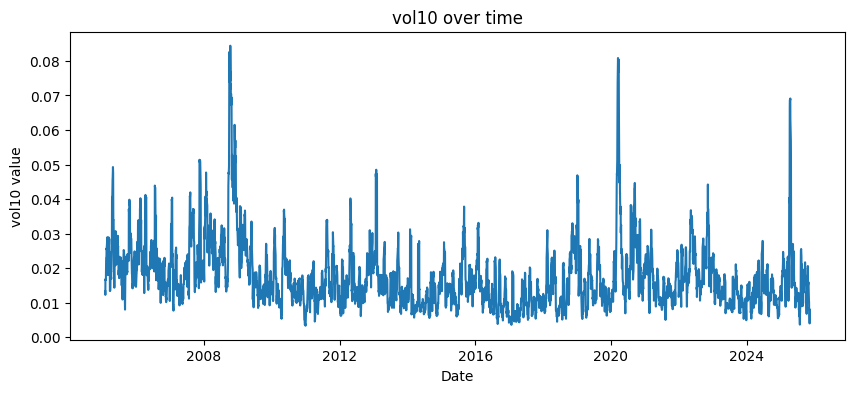

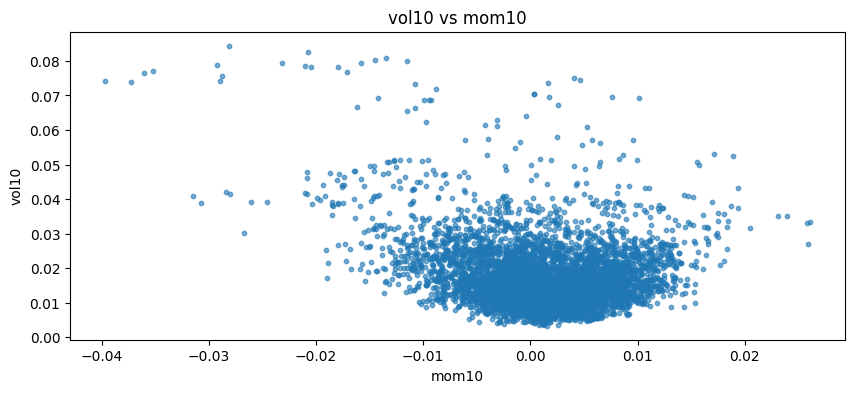

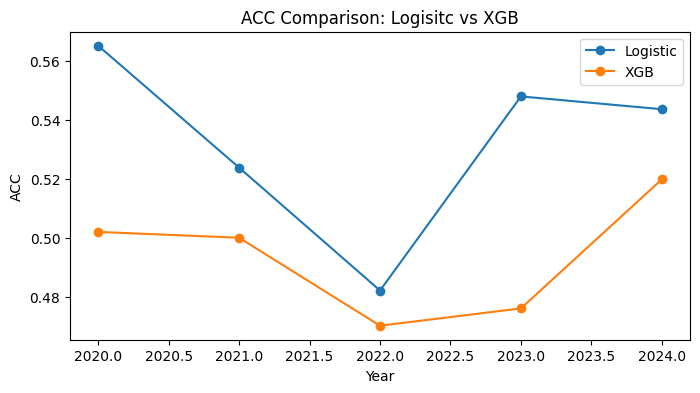

,year,acc_logistic,acc_xgb
0,2020,0.565217,0.501976
1,2021,0.523810,0.500000
2,2022,0.482072,0.470120
3,2023,0.548000,0.476000
4,2024,0.543651,0.519841


In [356]:
importlib.reload(nl_api)
with open(os.path.join(project_root, "llm_api", "catalog.json")) as f:
    catalog=json.load(f)

nl_api.set_env(
    df_ml=df_no_nan,
    results_logistic=results_logistic,
    results_xgb=results_xgb,
    catalog=catalog
)


nl_api.get_metric(2024, "logistic", "ACC")
nl_api.list_years("logistic")
nl_api.explain("bbp20")
nl_api.plot_feature("vol10")
nl_api.plot_scatter("mom10", "vol10")
nl_api.compare_models("acc")



